## 引入工具

In [164]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
# %watermark -p numpy,sklearn,pandas
# %watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
# %watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x):
    try: 
        x = x.strip()
        if x[0] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                uri = 'https://' + x
                x = requests.get(uri)
                if x.status_code == 200:
                    x = x.text
            elif x.startswith('github.com'):
                uri = x.replace('github.com', 'raw.githubusercontent.com')
                mod = uri.split('/')
                for s in ['main', 'master']:
                    uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[-3:])
                    x = requests.get(uri)
                    if x.status_code == 200:
                        x = x.text
                        break
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                for s in ['/raw/main/', '/raw/master/']:
                    uri = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[3:])
                    x = requests.get(uri)
                    if x.status_code == 200:
                        x = x.text
                        break
        exec(x, globals())
    except:
        pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)


## 解析配置

In [165]:
_IMPORT('/data/nb_easy/easy_widget.py')

In [305]:
from utils import EVENTS

RACEURL = 'http://116.85.68.193:9119'
MSGKEY = 'nb.zmq.repnet_tf.gamma103'

with open('schema.json', 'r') as fr:
    schema_string = fr.read()
    schema_string = schema_string.replace('zmq.repnet_tf.test', MSGKEY)
    schema_string = schema_string.replace('http://host:port', RACEURL)
    schema = json.loads(schema_string)
easy = nbeasy_schema_parse(schema, events=EVENTS, debug=True);

Box(children=(Box(children=(VBox(children=(Tab(children=(VBox(children=(HBox(children=(Text(value='zmq.repnet_…

In [167]:
raise

RuntimeError: No active exception to reraise

1. https://frepai.s3.didiyunapi.com/datasets/vod/木槌加固/20211206123823.mp4

In [191]:
import numpy as np
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA

In [173]:
def _denormal_image(x):
    x -= x.mean()
    x /= x.std()
    x *= 64
    x += 128
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Datasets

In [ ]:
EMBS_DIR = '/data/embs'

In [168]:
%%bash

DST_DIR=/data/embs
URL_PREFIX=https://frepai.s3.didiyunapi.com/datasets/vod/outputs

FILES=(
    '20211130112549/1638626932'
    '20211201074745/1638627005'
    '20211201110905/1638627357'
    '20211201161714/1638627646'
    '20211203163819/1638629398'
    '20211203164823/1638627707'
    '20211203172839/1638627775'
    '20211204105928/1638627847'
    '20211204110932/1638629800'
    '20211204152111/1638627907'
    '20211206105743/1638779824'
    '20211206135855/1638779140'
    
    
    '20211201095837/1638627981'
    '20211204124008/1638629958'
    '20211204144055/1638628049'
)

for file_ts in ${FILES[@]}
do
    file=`echo $file_ts | cut -d/  -f1`
    if [[ ! -f $DST_DIR/${file}_feat.npy ]]
    then
        echo $DST_DIR $URL_PREFIX/$file_ts/embs_sims.npy
        wget -q -P $DST_DIR $URL_PREFIX/$file_ts/embs_sims.npy
        echo $DST_DIR $URL_PREFIX/$file_ts/embs_feat.npy
        wget -q -P $DST_DIR $URL_PREFIX/$file_ts/embs_feat.npy
        mv $DST_DIR/embs_feat.npy $DST_DIR/${file}_feat.npy
        mv $DST_DIR/embs_sims.npy $DST_DIR/${file}_sims.npy
    fi
done

### Pos Datasets

In [229]:
pos_embs_files = (
    '20211130112549',
    '20211201074745',
    '20211201110905',
    '20211201161714',
    '20211203163819',
    '20211203164823',
    '20211203172839',
    '20211204105928',
    '20211204110932',
    '20211204152111',
    '20211206135855',
    '20211206135855',
)

In [246]:
pos_feat_list = []
for s in pos_embs_files:
    pos_feat_list.append(np.load(f'{EMBS_DIR}/{s}_feat.npy'))
    
pos_feat_np = np.vstack(pos_feat_list)
pos_feat_np.shape

(68, 64, 512)

In [ ]:
pos_sims_list = []
for s in pos_embs_files:
    pos_sims_list.append(np.load(f'{EMBS_DIR}/{s}_sims.npy')[1:-1])
    
pos_sims_np = np.vstack(pos_sims_list)
pos_sims_np.shape

#### A

In [322]:
feat_np_905 = np.load(f'{EMBS_DIR}/20211201110905_feat.npy')
feat_np_905.shape

(4, 64, 512)

In [323]:
feat_np_905_512 = feat_np_905.reshape(-1, 512)

In [324]:
pca24 = PCA(n_components=24)
pca24.fit(feat_np_905_512)

PCA(n_components=24)

In [325]:
np.cumsum(pca24.explained_variance_ratio_)[-1]

0.80003583

In [326]:
feat_np_905_out = pca24.transform(feat_np_905_512)

In [330]:
feat_np_905_out[:64, 0]

array([-3.7582622 , -3.7651746 , -1.5881492 ,  1.1798987 ,  2.606003  ,
        3.201908  ,  3.1703942 ,  2.141558  , -0.6588715 , -3.0413718 ,
       -5.0282025 , -1.7746751 ,  0.5752642 ,  2.9186592 ,  2.3210776 ,
        2.398951  ,  1.365288  , -0.3198794 , -2.5182958 , -4.1467447 ,
       -1.6829226 , -0.10574899,  2.035658  ,  2.7301698 ,  2.449008  ,
        2.8773527 , -0.40319222, -0.8171334 , -4.5931597 , -2.5641072 ,
       -2.015061  ,  1.7007217 ,  3.107739  ,  2.8782892 ,  2.9896555 ,
        1.2194232 , -0.19040835, -3.5688639 , -3.7379498 , -1.7402667 ,
        0.7785674 ,  2.0469723 ,  2.4344985 ,  2.6937366 ,  2.2775836 ,
        0.64150447, -1.3915277 , -3.6090686 , -3.1160045 , -1.399304  ,
        0.37766513,  2.338382  ,  3.135921  ,  3.0368872 ,  1.9132249 ,
       -0.07421626, -2.020869  , -3.7025433 , -3.1359882 , -1.7853978 ,
        0.63977253,  2.421041  ,  1.9158247 ,  1.0662906 ], dtype=float32)

#### B

In [172]:
a = pos_feat_np.reshape((-1, 512))

In [174]:
feats = []
for feat in a:
    feats.append(_denormal_image(feat))

In [176]:
feats_np = np.vstack(feats)

In [308]:
feats_np.shape

(4352, 512)

In [316]:
pca = PCA(n_components=64)
pca.fit(feats_np)

PCA(n_components=24)

In [317]:
np.cumsum(pca.explained_variance_ratio_)[-1]

0.6515302072957703

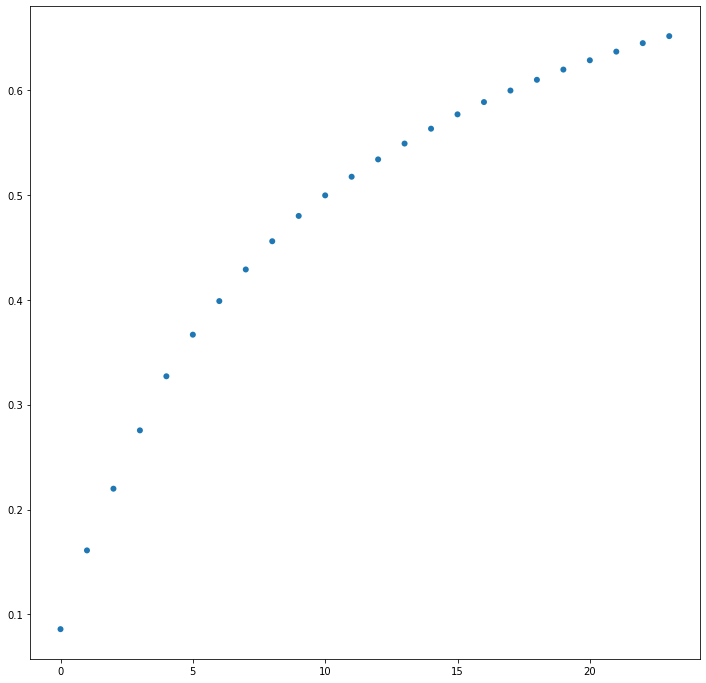

In [318]:
plot_scatter(np.cumsum(pca.explained_variance_ratio_))

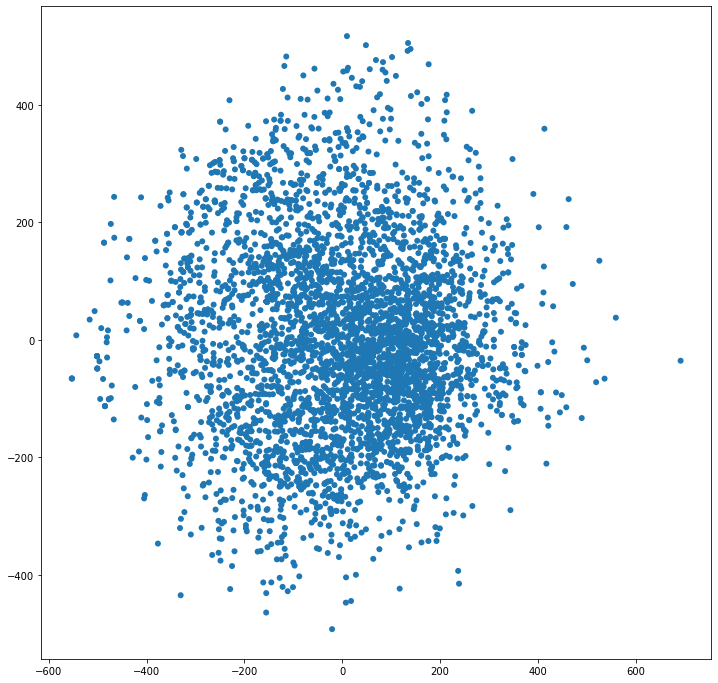

In [219]:
pos_feat_64 = pca.transform(feats_np)

pos_feat_64_0 = pos_feat_64 - pos_feat_64.mean(axis=0)
pos_feat_64_1 = pos_feat_64_0 - pos_feat_64_0.mean(axis=1).reshape((-1, 1))

plot_scatter(pos_feat_64_1)

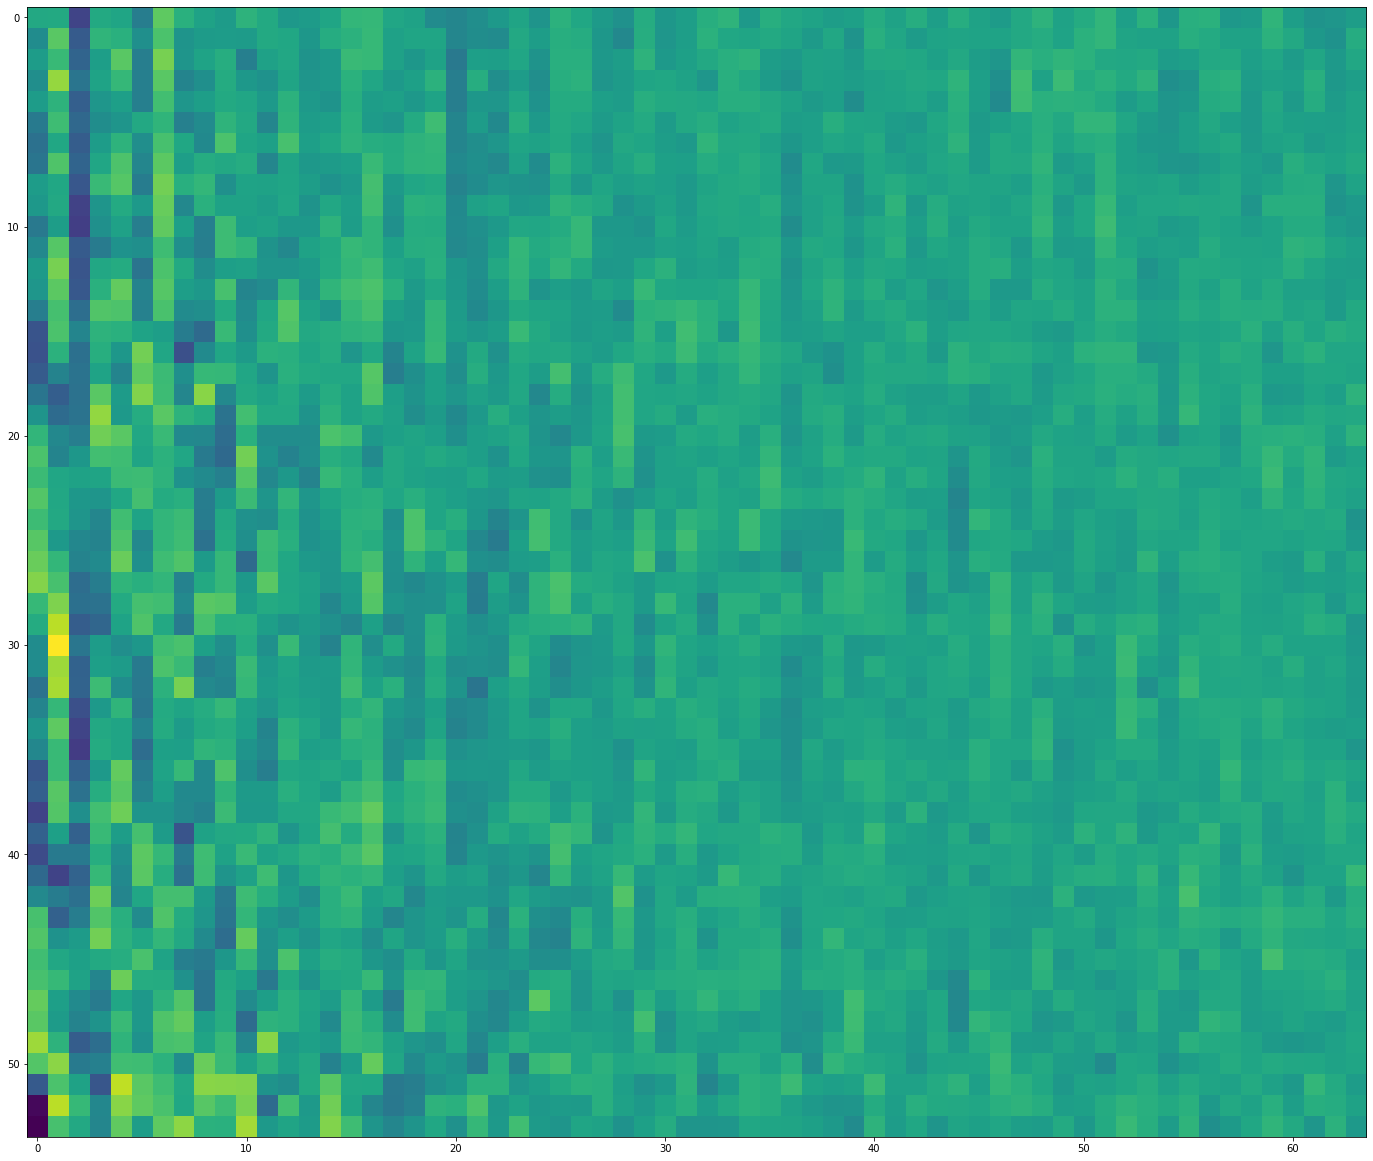

In [218]:
plt.figure(figsize=(24, 24))
plt.imshow(b[10:64])

### Neg Datasets

In [ ]:
neg_embs_files = (
    '20211201095837',
    '20211204124008',
    '20211204144055',
)

In [247]:
neg_feat_list = []
for s in neg_embs_files:
    neg_feat_list.append(np.load(f'{EMBS_DIR}/{s}_feat.npy'))
    
neg_feat_np = np.vstack(neg_feat_list)
neg_feat_np.shape

(15, 64, 512)

In [ ]:
neg_sims_list = []
for s in neg_embs_files:
    neg_sims_list.append(np.load(f'{EMBS_DIR}/{s}_sims.npy')[1:-1])
    
neg_sims_np = np.vstack(neg_sims_list)
neg_sims_np.shape

## PCA

In [ ]:
def plot_scatter(data, colors=None):
    if len(data.shape) != 2:
        xs = range(len(data))
        ys = data
    else:
        if data.shape[1] == 1:
            ys = data[:, 0]
            xs = range(len(data))
        else:
            xs = data[:, 0]
            ys = data[:, 1]
        
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    ax.scatter(xs, ys, c=colors, edgecolor='none', cmap=plt.cm.get_cmap('Paired', 2))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

### Feat

In [263]:
pos_feat_512 = pos_feat_np.reshape((-1, 512)).copy()
neg_feat_512 = neg_feat_np.reshape((-1, 512)).copy()
pos_feat_512.shape, neg_feat_512.shape

((4352, 512), (960, 512))

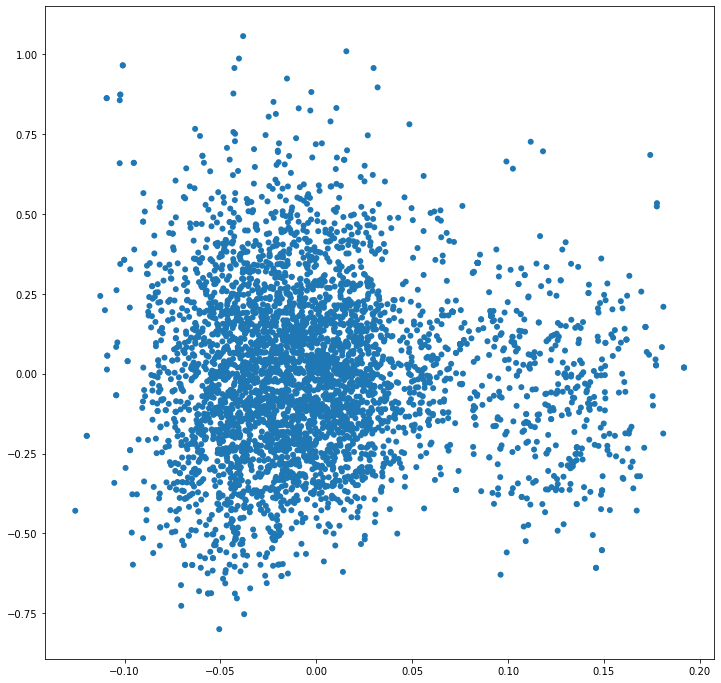

In [232]:
pos_feat_512_0 = pos_feat_512 - pos_feat_512.mean(axis=0)
pos_feat_512_1 = pos_feat_512_0 - pos_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(pos_feat_512_1)

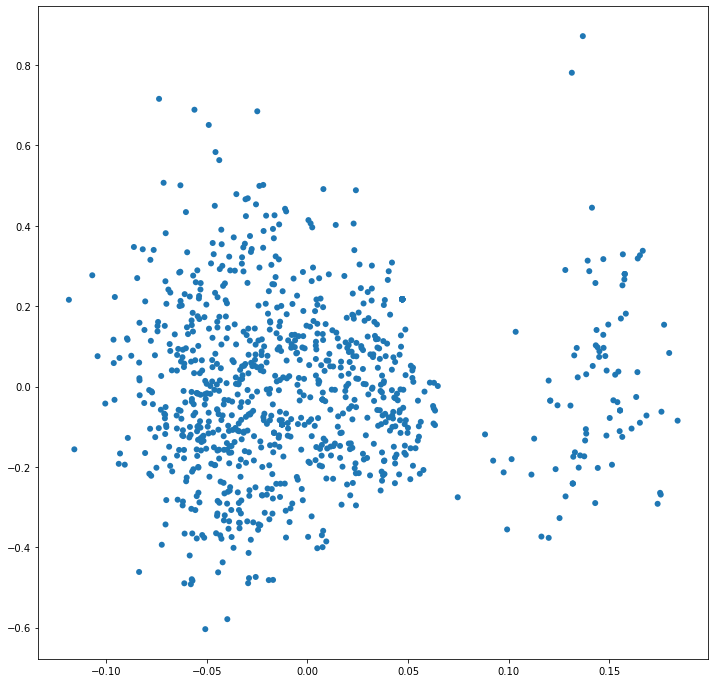

In [233]:
neg_feat_512_0 = neg_feat_512 - neg_feat_512.mean(axis=0)
neg_feat_512_1 = neg_feat_512_0 - neg_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(neg_feat_512_1)
# neg_feat_512_1[100:120]

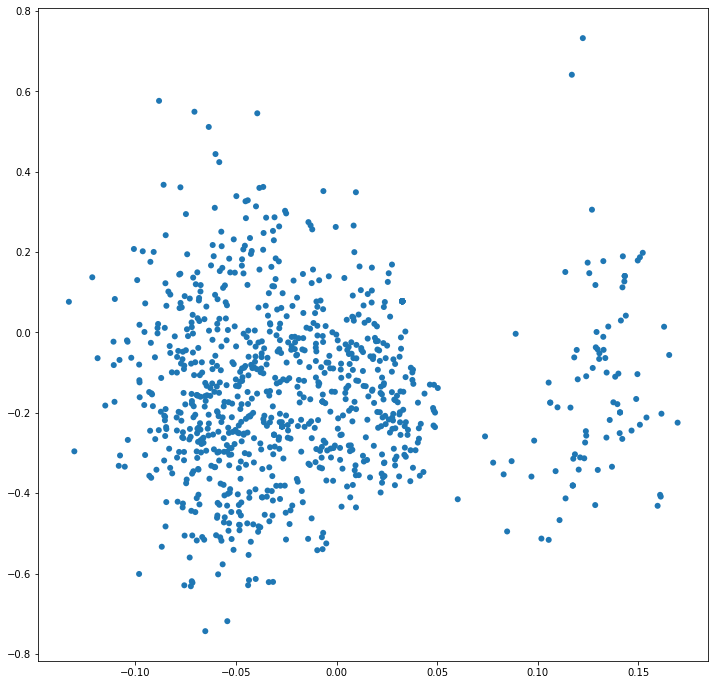

In [239]:
neg_feat_512_0 = neg_feat_512 - pos_feat_512.mean(axis=0)
neg_feat_512_1 = neg_feat_512_0 - neg_feat_512_0.mean(axis=1).reshape((-1, 1))

plot_scatter(neg_feat_512_1)
# neg_feat_512_1[100:120]

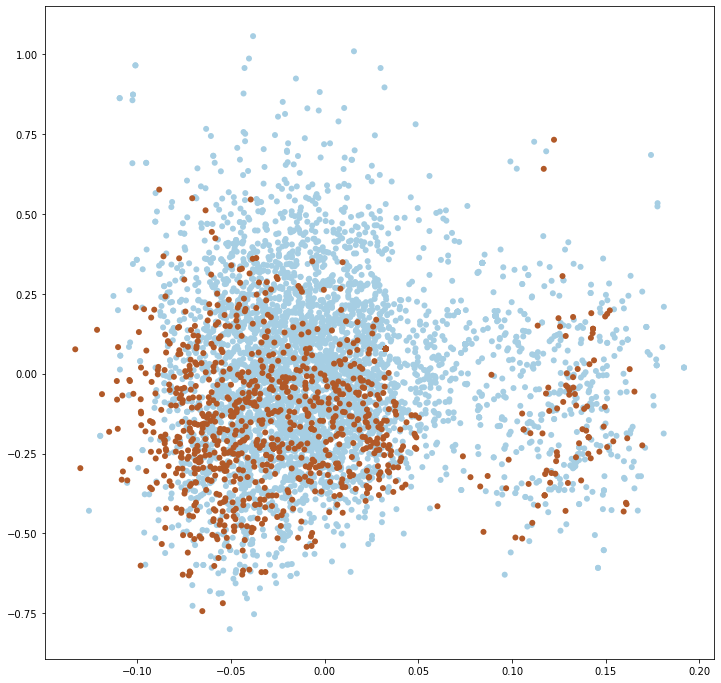

In [235]:
targets = [0] * pos_feat_512.shape[0] + [1] * neg_feat_512.shape[0]
# plot_scatter(pos_output, colors=targets)
plot_scatter(np.vstack([pos_feat_512_1, neg_feat_512_1]), colors=targets)

In [264]:
pca = PCA(n_components=32)
pca.fit(pos_feat_512)

PCA(n_components=32)

In [265]:
pos_feat_512[1, :10]

array([0.        , 0.8010101 , 0.6195019 , 0.8324692 , 0.        ,
       0.62644315, 0.        , 0.53295994, 1.0064402 , 0.5975261 ],
      dtype=float32)

In [266]:
np.cumsum(pca.explained_variance_ratio_)[-1]

0.7137782

In [294]:
# pos_feat_32 = pca.transform(np.concatenate([pos_feat_512, neg_feat_512], axis=0))
pos_feat_32 = pca.transform(pos_feat_512)
neg_feat_32 = pca.transform(neg_feat_512)

In [295]:
len(pos_feat_512)

4352

In [293]:
neg_feat_32.shape

(960, 32)

In [269]:
np.percentile(pos_feat_32[:, 0], [25, 75])

array([-1.24389029,  0.95506355])

In [301]:
indexes = []
means = []
stds = []
for i in range(32):
    indexes.append(outlier_detection(pos_feat_32[:, i])[0])
    means.append(pos_feat_32[:, i].mean())
    stds.append(pos_feat_32[:, i].std())

In [300]:
# means, stds

In [ ]:
for f in neg_feat_32:
    flg = 0
    for i in range(32):
        f[i] - means
        print()

In [302]:
outlier_index = np.unique(np.concatenate(indexes))

In [303]:
len(outlier_index)

29

In [304]:
outlier_index[-300:]

array([  76, 2200, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223,
       2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234,
       2235, 2236, 2509, 2524, 3040, 3776, 4096])

In [278]:
outlier_detection(pos_feat_32[:, 0])

(array([ 130,  144,  194,  256,  258,  448,  449,  450,  512,  513,  514,
         576,  577,  578,  638,  639,  640,  641,  642,  701,  704,  705,
         706,  768,  769,  770,  830,  831,  832,  833,  834,  893,  894,
         895,  896,  897,  960,  961,  962, 1025, 1026, 1088, 1089, 1090,
        1152, 1153, 1216, 1217, 1218, 1280, 1281, 1282, 1342, 1343, 1344,
        1345, 1407, 1408, 1409, 1410, 1470, 1471, 1472, 1473, 1474, 1536,
        1537, 1538, 1598, 1599, 1602, 1661, 1662, 1663, 1664, 1665, 1666,
        1728, 1729, 1730, 1792, 1793, 1794, 1856, 1857, 1920, 2048, 2049,
        2050, 2176, 2177, 2240, 2241, 2301, 2302, 2303, 2304, 2305, 2306,
        2368, 2369, 2370, 2430, 2431, 2432, 2433, 2434, 2496, 2497, 2498,
        2560, 2561, 2622, 2624, 2625, 2626, 2690, 2754, 2880, 2881, 2882,
        2945, 2946, 3010, 3072, 3073, 3074, 3136, 3137, 3138, 3200, 3201,
        3202, 3264, 3266, 3328, 3330, 3392, 3393, 3394, 3456, 3457, 3458,
        3517, 3518, 3519, 3520, 3521, 

In [237]:
pos_feat_64 = pca.transform(pos_feat_512_1)
neg_feat_64 = pca.transform(neg_feat_512_1)

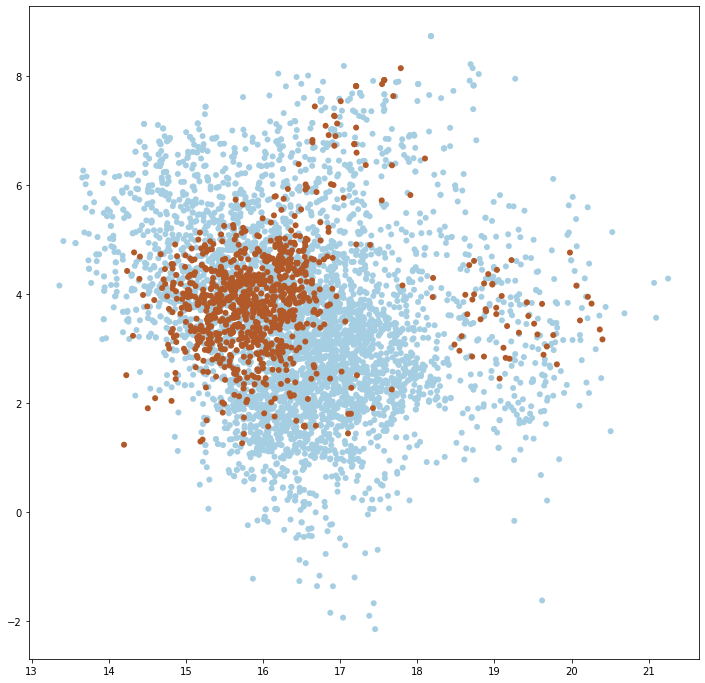

In [238]:
targets = [0] * pos_feat_64.shape[0] + [1] * neg_feat_64.shape[0]
plot_scatter(np.vstack([pos_feat_64, neg_feat_64]), colors=targets)

In [ ]:
pos_output_1 = pca.fit_transform(pos_feat_512)
pos_output_2 = pca.fit_transform(neg_feat_512)

In [ ]:
targets = [0] * pos_feat_512.shape[0] + [1] * neg_feat_512.shape[0]
# plot_scatter(pos_output, colors=targets)
plot_scatter(np.vstack([pos_output_1, pos_output_2]), colors=targets)

### Sims

In [ ]:
tril = np.tril_indices(64)

In [ ]:
pos_sims_tril = pos_sims_np[:, tril[0], tril[1]]
neg_sims_tril = neg_sims_np[:, tril[0], tril[1]]

In [ ]:
pos_sims_tril.shape, neg_sims_tril.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline_sims = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])
# pca_sims = PCA(n_components=2)
# pca_sims.fit(pos_sims_tril)
pipeline_sims.fit(pos_sims_tril)

In [ ]:
pca = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=10))])

In [ ]:
pca.fit(pos_sims_tril)

In [ ]:
pca['pca'].explained_variance_ratio_

In [ ]:
# !pip3 install pyod  --trusted-host  mirrors.aliyun.com -i https://mirrors.aliyun.com/pypi/simple

In [ ]:
from pyod.models.pca import PCA

In [ ]:
clf = PCA(n_components=2)
clf.fit(pos_sims_tril)

In [ ]:
print(clf.labels_)

In [ ]:
clf.predict(neg_sims_tril)

In [ ]:
pos_sims_output = pipeline_sims.transform(pos_sims_tril)
neg_sims_output = pipeline_sims.transform(neg_sims_tril)
pos_sims_output.shape, neg_sims_output.shape

In [ ]:
pos_sims_output.std(), neg_sims_output.std(), pos_sims_output.mean(), neg_sims_output.mean()

In [ ]:
neg_sims_output

In [ ]:
pos_sims_output = pca_sims.transform(pos_sims_tril)
neg_sims_output = pca_sims.transform(neg_sims_tril)
pos_sims_output.shape, neg_sims_output.shape

In [ ]:
targets = [0] * pos_sims_tril.shape[0] + [1] * neg_sims_tril.shape[0]
plot_scatter(np.vstack([pos_sims_output, neg_sims_output]), colors=targets)

## A

In [ ]:
sims = ('20211130112549', '20211201074745', '20211201110905', '20211201161714')
pos_sims_list = []
for s in sims:
    pos_sims_list.append(np.load(f'/data/sims/{s}.npy'))
    
neg_sims = np.load(f'/data/sims/20211130112549.npy')

In [ ]:
pca0 = PCA()

In [ ]:
pca = PCA(n_components=2)

In [ ]:
data = np.vstack(pos_sims_list) # np.concatenate(sims_list)

In [ ]:
il1 = np.tril_indices(64)

In [ ]:
neg_features = neg_sims[:, il1[0], il1[1]]
neg_features.shape

In [ ]:
neg_features.var(axis=1)

In [ ]:
features = data[:, il1[0], il1[1]]

In [ ]:
features.shape

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

In [ ]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
features.shape

In [ ]:
pca0 = PCA().fit(features)
plt.plot(np.cumsum(pca0.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca_pos_out = pca.fit_transform(features)
pca_pos_out.var(), pca_pos_out.mean()

In [ ]:
pca_pos_out.std(axis=1)

In [ ]:
pca_neg_out = pca.fit_transform(neg_features)
pca_neg_out.var(), pca_neg_out.mean()

In [ ]:
pca_neg_out.std(axis=1)

In [ ]:
pca.explained_variance_

In [ ]:
pca.mean_, pca.explained_variance_ratio_

In [ ]:
plot_scatter(pca_pos_out)

In [ ]:
plot_scatter(pca_neg_out)

### TSNE

In [ ]:
tsne = TSNE(random_state=0)

In [ ]:
Xt = pca.fit_transform(features)
plt.scatter(Xt[:,0], Xt[:,1])

In [ ]:
Nt = pca.transform(neg_features)
plt.scatter(Nt[:,0], Nt[:,1])

In [ ]:
pca.explained_variance_ratio_

In [ ]:
tsne_results = tsne.fit_transform(features)

In [ ]:
plot_scatter(tsne_results)

### B

In [ ]:
qg_embs1 = np.load('/data/repnet_embs_qg_1.npy')
qg_embs1.shape

In [ ]:
qg_features_1 = qg_embs1[1:10].reshape(-1, 512)
qg_features_1.shape

In [ ]:
qg_tsne_1 = tsne.fit_transform(qg_features_1)

In [ ]:
plot_scatter(qg_tsne_1)

### C

In [ ]:
mz_embs1 = np.load('/data/repnet_embs_mz_1.npy')
mz_embs1.shape

In [ ]:
mz_features_1_ = mz_embs1.reshape(-1, 512)
mz_features_1_.shape

In [ ]:
mz_tsne_1_ = tsne.fit_transform(mz_features_1_)

In [ ]:
plot_scatter(mz_tsne_1_)

In [ ]:
mz_features_1 = mz_embs1[1:10].reshape(-1, 512)
mz_features_1.shape

In [ ]:
mz_tsne_1 = tsne.fit_transform(mz_features_1)

In [ ]:
plot_scatter(mz_tsne_1)

## 视频描述

## C

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [ ]:
X.shape

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

In [ ]:
PCA()

In [ ]:
print(pca.components_)

In [ ]:
print(pca.explained_variance_)

## D

```py
    def remover_outlier(self, x_pca, y_pca, x, y, label):
        # outlier_index = np.where((x_pca[:, 0:5] < -200) | (x_pca[:, 0:5] > 35))[0]
        outlier_x =[]
        for i in range(x_pca.shape[1]):
            outlier_x.append(self.outlier_detection(x_pca[:, i])[0])
        outlier_index = np.unique(np.concatenate(outlier_x))

        x_pca = np.delete(x_pca, outlier_index, axis=0)
        y_pca = np.delete(y_pca, outlier_index, axis=0)
        x = np.delete(x, outlier_index, axis=0)
        y = np.delete(y, outlier_index, axis=0)
        label = label.drop(index=outlier_index).reset_index(drop=True)
        return x_pca, y_pca, x, y, label

    def outlier_detection(self, data):
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - (iqr * 1.5)
        upper_bound = q3 + (iqr * 1.5)
        return np.where((data < lower_bound) | (data > upper_bound))
```

In [299]:
def outlier_detection(data):
    q1, q3 = np.percentile(data, [15, 85])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((data < lower_bound) | (data > upper_bound))